<a href="https://colab.research.google.com/github/santboia/Curs_CausalDS/blob/main/lecture_notes/dowhy_use_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Propensity Score Stratification with Dowhy to de-bias causal estimates

In this notebook we introduce the use of propensity score methods as provided by Microsoft's DoWhy library to estimate the magnitude of causal effects.

We illustrate this by analysing fictitious hotel booking data data. More specifically, we study the effect of changing the room booked (*intervention* or *treatment*) on the number of booking cancellations (*outcome*).

There can be different reasons for why a booking is cancelled. A customer may have requested something that was not available (e.g., car parking), a customer may have found later that the hotel did not meet their requirements, or a customer may have simply cancelled their entire trip. Some of these, like car parking, are actionable by the hotel whereas others, like trip cancellation, are outside the hotel’s control. In any case, we would like to better understand which of these factors cause booking cancellations.

This analysis is based on a hotel bookings dataset from [Antonio, Almeida and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191). On GitHub, the dataset is available at [rfordatascience/tidytuesday](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md).

## Load packages and data

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# install dowhy
import sys
!{sys.executable} -m pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 123 kB 29.6 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [3]:
# load data:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

### Feature Engineering

Lets create some new and meaningful features so as to reduce the dimensionality of the dataset.
- `total_stay` = stays_in_weekend_nights + stays_in_week_nights
- `guests` = adults + children + babies 
- `different_room_assigned` = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise.

In [5]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights'] + dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults'] + dataset['children'] + dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned'] = 0
slice_indices = dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices, 'different_room_assigned'] = 1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights', 'stays_in_weekend_nights',
                        'adults', 'children', 'babies','reserved_room_type',
                        'assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [6]:
# Data cleaning: 

# Remove other columns that either contain NULL values or 
# have too many unique values (e.g., agent ID). 
dataset = dataset.drop(['reservation_status', 'reservation_status_date',
                        'arrival_date_day_of_month'], axis=1)
dataset = dataset.drop(['arrival_date_year'], axis=1)
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'], axis=1)

# Impute missing countries with most frequently occuring country:
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

# Remove distribution_channel since it has a high overlap with market_segment.
dataset = dataset.drop(['distribution_channel'], axis=1)

In [7]:
# Replacing 1 by True and 0 by False for the treatment and outcome variables:
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
print(dataset.columns)
# Show some data for visual exploration:
dataset.iloc[:, 5:20].head(100)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,73.80,0,1,2,2.0
96,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,117.00,0,1,7,2.0
97,HB,ESP,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0,1,7,3.0
98,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,99.30,1,2,7,3.0


In [10]:
# Keep only bookings with `deposit_type`="No Deposit"
# as these are the great majority and sufficient for the present analysis:
dataset.deposit_type.value_counts()

No Deposit    104637
Non Refund     14587
Refundable       162
Name: deposit_type, dtype: int64

In [11]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  ...  guests  different_room_assigned
deposit_type is_canceled                    ...                                 
No Deposit   False        74947      74947  ...   74947                    74947
             True         29690      29690  ...   29690                    29690

[2 rows x 19 columns]

In [12]:
dataset_copy = dataset.copy(deep=True)

## Naive approach

Since the number of cancellations and the number of times a different room was assigned are heavily imbalanced, we first choose 1000 observations at random to see that in how many cases do the variables `is_cancelled` and `different_room_assigned` attain the same values. 

We repeat this process 10,000 times. We find that the expected count turns out to be near 50% (i.e. the probability of these two variables attaining the same value appears to be random). 

So statistically speaking, we have no definite conclusion at this stage. In other words, assigning rooms different to what a customer had reserved during his booking earlier, may or may not lead to him/her cancelling that booking.

In [14]:
counts_sum=0
nsample = 1000
nrepeat = 10000
for i in range(1,nrepeat):
        counts_i = 0
        rdf = dataset.sample(nsample)
        counts_i = rdf[ rdf["is_canceled"]==rdf["different_room_assigned"] ].shape[0]
        counts_sum+= counts_i
print("probab(cancelled & diff_room)=", counts_sum/(nsample * nrepeat) )

probab(cancelled & diff_room)= 0.588602


We now consider the scenario when there were no booking changes and recalculate the expected count.

In [15]:
counts_sum=0
nsample = 1000
nrepeat = 10000
for i in range(1,nrepeat):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[ rdf["is_canceled"]==rdf["different_room_assigned"] ].shape[0]
        counts_sum+= counts_i
print("probab(cancelled & diff_room|no_book_change)=", 
      counts_sum/(nsample * nrepeat) )

probab(cancelled & diff_room|no_book_change)= 0.5726602


Finally, we consider the scenario when there were booking changes(>0) and recalculate the expected count:

In [ ]:
counts_sum=0
nsample = 1000
nrepeat = 10000
for i in range(1,nrepeat):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[ rdf["is_canceled"]==rdf["different_room_assigned"] ].shape[0]
        counts_sum+= counts_i
print("probab(cancelled & diff_room|no_book_change)=", 
      counts_sum/(nsample * nrepeat) )

There is definitely some change happening when the number of booking changes are non-zero. So it gives us a hint that Booking Changes must be a *confounding variable*.

## Creating a causal graph

We now generate a causal graph that we will feed into DoWhy to generate causal estimates.

This graph reflects the following assumptions stemming from business knowledge underlying the current problem:
- `Market Segment` has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the Lead Time (which is simply the number of days between booking and arrival).
- `Country` would also play a role in deciding whether a person books early or not (hence more Lead Time) and what type of Meal a person would prefer.
- `Lead Time` would definitely affect the number of Days in Waitlist (there are fewer chances of finding a reservation if you’re booking late). Additionally, higher Lead Times can also lead to Cancellations.
- The number of `Days in Waitlist`, the `Total Stay` in nights and the number of `Guests` might affect whether the booking is cancelled or retained.
- `Previous Booking Retentions` would affect whether a customer is a `Repeated Guest` or not. Additionally, both of these variables would affect whether the booking gets cancelled or not (e.g., a customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling their bookings has a higher chance of doing the same).
- `Booking Changes` would affect whether the customer is assigned a `different room` or not which might also lead to cancellation.
- Finally, the number of `Booking Changes` being the only confounder affecting `Treatment` and `Outcome` is highly unlikely and its possible that there might be some `Unobsevered Confounders`, regarding which we have no information captured in our data.



In [26]:
# install libgraphviz and pygraphviz for nicer-looking graphs:
!apt install libgraphviz-dev
import sys
!{sys.executable} -m pip install pygraphviz
import pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

In [19]:
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->different_room_assigned; U->is_canceled;U->required_car_parking_spaces;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> is_canceled;
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> is_canceled;
country->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
}"""

## Create a CausalModel object

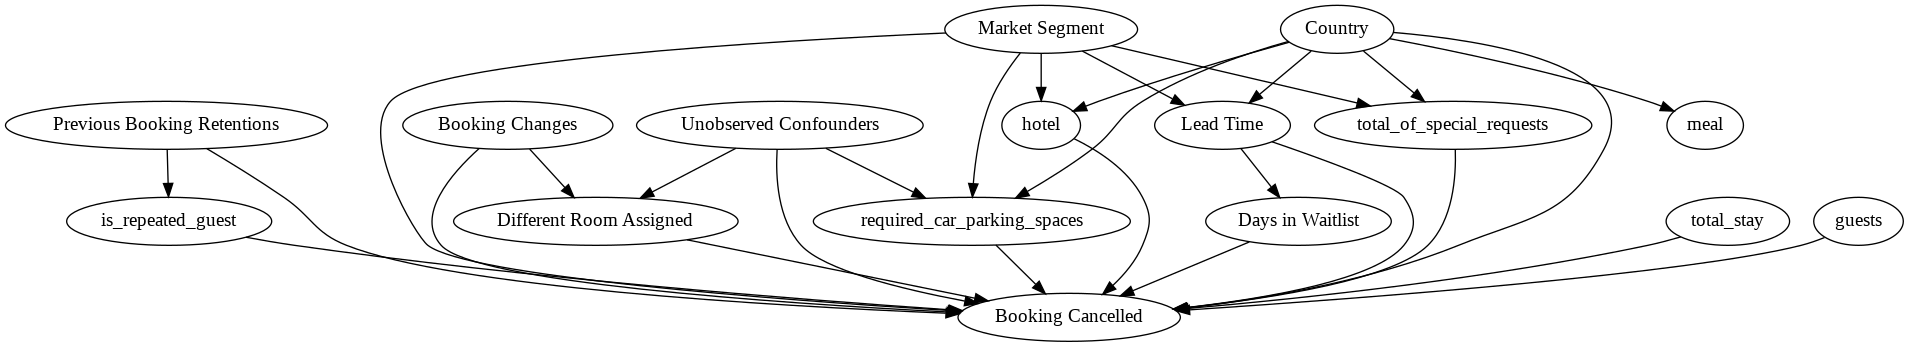

In [27]:
# Instantiate a causal model with:
#   Treatment = assigning the same type of room reserved by the customer during Booking. 
#   Outcome = whether the booking was cancelled or not. 
#   Common Causes  = variables that according to our business knowledge assumptions have a causal affect on both Outcome and Treatment. 
# If we are not specifying the graph explicitly (Not Recommended!), one can also provide these as parameters in the function mentioned below.
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Identification of the causal effect

By using properties of the causal graph, we identify the causal effect to be estimated:

In [21]:
#import statsmodels
#Identify the causal effect:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|guests,meal,total_of_specia
d[different_room_assigned]                                                    

                                                                              
l_requests,is_repeated_guest,required_car_parking_spaces,hotel,days_in_waiting
                                                                              

                                                                              
_list,country,total_stay,previous_bookings_not_canceled,booking_changes,market
                                                                              

                    
_segment,lead_time))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_ass

## Provide a numerical estimate of the identified estimand

Here, we tell DoWhy to use a *propensity score stratification* method to account for the different distribution of *treatment* values among covariates.

We ask it to provide an estimate of the *average treatment effect* (ATE):
$ ATE = E[Y(T=1)] - E[Y(T=0)]$

Other possible estimates are:
-  ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room): $ATT = E[Y(T=1)-Y(T=0)|T=1] =  E[Y(T=1)|T=1] - E[Y(T=0)|T=1]$
- ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room), $ATC = E[Y(T=1)-Y(T=0)|T=0] =  E[Y(T=1)|T=0] - E[Y(T=0)|T=0]$

Note the clear *counterfactual* nature of both these causal effects. 
For instance, in ATT, 
the first term is the average number of cancellations among rooms that were changed, a potentially observable quantity. 
The second term is the average number of cancellations
among rooms that were *not* changed *if they had been changed*: this cannot be observed, though we may have a control group or modelling strategy that provides a consistent estimate.

In [22]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",
                                 target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|guests,meal,total_of_specia
d[different_room_assigned]                                                    

                                                                              
l_requests,is_repeated_guest,required_car_parking_spaces,hotel,days_in_waiting
                                                                              

                                                                              
_list,country,total_stay,previous_bookings_not_canceled,booking_changes,market
                                                                              

                    
_segment,lead_time))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→i

We obtain a negative ATE, which means that having a different room assigned *decreases* the chances of a cancellation. This is the *opposite* of what our initial naive associational analysis suggested.

Does this surprise you?

Could it be that different rooms are assigned only when the booked room is unavailable, and therefore assigning a different room has a positive effect on the customer (as opposed to not assigning a room)?

There could also be other mechanisms at play. Perhaps assigning a different room only happens at check-in, and the chances of a cancellation once the customer is already at the hotel are low? In that case, the graph is missing a critical variable on when these events happen. Does `different_room_assigned` happen mostly on the day of the booking? Knowing that variable can help improve the graph and our analysis.

While the associational analysis earlier indicated a positive correlation between `is_canceled` and `different_room_assigned`, estimating the causal effect using DoWhy presents a different picture. It implies that a decision/policy to reduce the number of `different_room_assigned` at hotels may be counter-productive.

## Refuting the causal estimate

We emphasize again that the causal estimate does not come from data alone. It comes from our assumptions (represented in the causal graph), which underpin the identification step. 

Data is simply used for statistical estimation. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

A first-principles verification of assumptions is out of the question, but we can subject our results to a number of refutation attempts -- if all come back as expected, we gain confidence that our causal graph is a good representation of the real-world situation.

We now describe some of the refutation methods available on DoWhy:

- *Random Common Cause:* Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [23]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.25088122292085513
New effect:-0.24901100336874274



- *Placebo Treatment Refuter*: Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.


In [24]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

KeyboardInterrupt: ignored

- *Data Subset Refuter*: Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.


In [25]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

KeyboardInterrupt: ignored

We see that our estimate passes all three refutation tests. This does not prove its correctness, but it increases confidence in the estimate.

## Acknowledgement

This introductory notebook is inspired by DoWhy's "starter notebook" [here](https://microsoft.github.io/dowhy/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html)